# 04: Radiomics Analysis

This notebook integrates **imaging-derived features** with clinical data to test whether tumour characteristics from MRI add predictive value beyond clinical and molecular markers.

**Key discovery:**
The MU-Glioma-Post dataset provides pre-extracted segmentation volume features, eliminating the need for PyRadiomics processing of raw NIfTI volumes.

**Features available (per timepoint):**
- Tumour volume (mm³)
- Intensity statistics (mean, stdev) for each MRI modality (T1c, T1n, T2f, T2w)

**Approach:**
1. Extract first-timepoint imaging features (avoids temporal leakage)
2. Merge with clinical data
3. Compare: Clinical-only vs Imaging-only vs Combined

**Expected outcome:**
Determine whether imaging features provide complementary prognostic information or are redundant with clinical/molecular markers.

## Setup

### Core Imports

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

### Model Imports

In [40]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr

### Mount Drive & Set Paths

In [41]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

from google.colab import userdata
GLIOMA_DIR = userdata.get('GLIOMA_DIR')
print(f"Glioma directory: {GLIOMA_DIR}")

Mounted at /content/drive/
Glioma directory: drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post


In [42]:
figures_dir = os.path.join(GLIOMA_DIR, 'results', 'figures')
os.makedirs(figures_dir, exist_ok=True)
print(f"Figures directory: {figures_dir}")

Figures directory: drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post/results/figures


## Load Data

### Load Clinical Data

In [43]:
preprocessed_dir = os.path.join(GLIOMA_DIR, 'preprocessed')

high_fill_df = pd.read_pickle(os.path.join(preprocessed_dir, 'high_fill_df.pkl'))
X = pd.read_pickle(os.path.join(preprocessed_dir, 'X.pkl'))
y = pd.read_pickle(os.path.join(preprocessed_dir, 'y.pkl'))

print(f"Clinical data loaded: {high_fill_df.shape}")
print(f"X: {X.shape}, y: {y.shape}")
print(f"\nTarget distribution:")
print(f"  Survived: {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
print(f"  Died: {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")

Clinical data loaded: (203, 29)
X: (203, 28), y: (203,)

Target distribution:
  Survived: 106 (52.2%)
  Died: 97 (47.8%)


### Load Segmentation Volumes

In [44]:
# Load the sheet with best patient coverage
seg_path = os.path.join(GLIOMA_DIR, 'MU_Glioma_Post_Segmentation_Volumes.xlsx')
seg_df = pd.read_excel(seg_path, sheet_name='Tumor Infiltration and Edema')

print(f"Segmentation data loaded: {seg_df.shape}")
print(f"Unique patients: {seg_df['Patient ID'].nunique()}")
print(f"\nColumns:")
for col in seg_df.columns:
    print(f"  - {col}")

Segmentation data loaded: (614, 13)
Unique patients: 321

Columns:
  - Patient ID
  - Label Id
  - Label Name
  - Number Of Voxels
  - Volume (mm^3)
  - Image mean (brain_t1c)
  - Image stdev (brain_t1c)
  - Image mean (brain_t1n)
  - Image stdev (brain_t1n)
  - Image mean (brain_t2f)
  - Image stdev (brain_t2f)
  - Image mean (brain_t2w)
  - Image stdev (brain_t2w)


### Examine Segmentation Data Structure

In [45]:
# Each row represents one timepoint for one patient
rows_per_patient = seg_df.groupby('Patient ID').size()

print("Timepoints per patient:")
print("-" * 23)
print(rows_per_patient.value_counts().sort_index().to_string())
print(f"\nPatients with 1 timepoint: {(rows_per_patient == 1).sum()}")
print(f"Patients with 2+ timepoints: {(rows_per_patient > 1).sum()}")

Timepoints per patient:
-----------------------
1    197
2     52
3     26
4     15
5     13
6     17
8      1

Patients with 1 timepoint: 197
Patients with 2+ timepoints: 124


### Normalise Patient IDs

The segmentation file uses two ID formats:
- Standard: `PatientID_XXXX` (145 patients)
- Extended: `PatientID_XXXX-Post-treatment_Y` (176 patients) - includes timepoint suffix

The extended format encodes timepoint information in the patient ID itself. We need to extract the base patient ID to match with clinical data.

In [46]:
import re

def extract_base_patient_id(patient_id):
    """Extract base patient ID (PatientID_XXXX) from any format."""
    match = re.match(r'(PatientID_\d{4})', str(patient_id))
    return match.group(1) if match else patient_id

# Apply to segmentation data
seg_df['patient_id'] = seg_df['Patient ID'].apply(extract_base_patient_id)

print(f"Original unique patient IDs: {seg_df['Patient ID'].nunique()}")
print(f"Normalised unique patient IDs: {seg_df['patient_id'].nunique()}")

Original unique patient IDs: 321
Normalised unique patient IDs: 202


## Extract First-Timepoint Features

To avoid temporal leakage, we use only the **first post-treatment MRI** for each patient. This represents the tumour state at a consistent clinical milestone.

In [47]:
# Extract first timepoint per patient (using normalised patient_id)
imaging_features = seg_df.groupby('patient_id').first().reset_index()

# Drop redundant columns
cols_to_drop = ['Patient ID', 'Label Id', 'Label Name', 'Number Of Voxels']
imaging_features = imaging_features.drop(columns=cols_to_drop, errors='ignore')

# Rename for clarity
rename_map = {
    'Volume (mm^3)': 'tumour_volume_mm3',
    'Image mean (brain_t1c)': 't1c_mean',
    'Image stdev (brain_t1c)': 't1c_std',
    'Image mean (brain_t1n)': 't1n_mean',
    'Image stdev (brain_t1n)': 't1n_std',
    'Image mean (brain_t2f)': 't2f_mean',
    'Image stdev (brain_t2f)': 't2f_std',
    'Image mean (brain_t2w)': 't2w_mean',
    'Image stdev (brain_t2w)': 't2w_std'
}
imaging_features = imaging_features.rename(columns=rename_map)

print(f"Imaging features extracted: {imaging_features.shape}")
print(f"Unique patients: {imaging_features['patient_id'].nunique()}")

Imaging features extracted: (202, 10)
Unique patients: 202


### Imaging Feature Statistics

In [48]:
feature_cols = [c for c in imaging_features.columns if c != 'patient_id']

print("Imaging Feature Summary")
print("-" * 23)

# Calculate descriptive statistics for imaging features
# Transpose for better readability
print(imaging_features[feature_cols].describe().T.to_string())

Imaging Feature Summary
-----------------------
                   count          mean           std         min           25%           50%           75%            max
tumour_volume_mm3  202.0  59092.688119  47418.449310  294.000000  20105.750000  49028.000000  85693.250000  226032.000000
t1c_mean           202.0    300.353596    168.475980  100.240214    213.624128    258.416628    340.155323    1967.501438
t1c_std            202.0     42.096891     20.686112   10.188981     31.076713     39.210841     51.237983     245.264044
t1n_mean           202.0    272.237159    118.421088   88.384383    207.282120    246.375025    289.710904     789.236659
t1n_std            202.0     40.274546     13.167371   10.167390     31.624896     38.726157     47.188490     106.924381
t2f_mean           202.0    324.940581    161.811219   44.062767    185.330371    284.576060    445.558016     775.107527
t2f_std            202.0     43.617376     21.823961    4.186886     25.647056     42.542854     5

### Sheet Analysis

The segmentation file contains four sheets representing different tumour subregions:

| Sheet | Tumour Region | Unique Patients |
|-------|---------------|-----------------|
| Necrotic Tumor Core (Label1) | Necrotic/dead tissue within tumour | 173 |
| Tumor Infiltration and Edema | Surrounding oedema and infiltration | 321 |
| Enhancing Tumor Core (Label3) | Active, contrast-enhancing tumour | 286 |
| Resection Cavity (Label4) | Post-surgical cavity | 291 |

**Decision:** Use "Tumor Infiltration and Edema" sheet as it has the highest patient coverage (321 patients), maximising overlap with our 203 clinical patients. This region also captures the full extent of tumour burden including surrounding tissue changes.

## Merge Clinical and Imaging Data

### Check Patient ID Alignment

In [49]:
# Clinical data needs patient_id from original X (which has it as a column or index)
# Reload to get patient_id, or use the index

# Option 1: If patient_id is in the original clinical data file
clinical_path = os.path.join(GLIOMA_DIR, 'MU_Glioma_Post_ClinicalData_July2025.xlsx')
clinical_raw = pd.read_excel(clinical_path, sheet_name='MU Glioma Post')
clinical_raw.columns = clinical_raw.columns.str.strip().str.lower()

clinical_patients = set(clinical_raw['patient_id'].values)
imaging_patients = set(imaging_features['patient_id'].values)

overlap = clinical_patients & imaging_patients
clinical_only = clinical_patients - imaging_patients
imaging_only = imaging_patients - clinical_patients

print("Patient Coverage")
print("-" * 16)
print(f"Clinical data: {len(clinical_patients)} patients")
print(f"Imaging data:  {len(imaging_patients)} patients")
print(f"Overlap:       {len(overlap)} patients")
print(f"\nClinical only (no imaging): {len(clinical_only)}")
print(f"Imaging only (no clinical): {len(imaging_only)}")

Patient Coverage
----------------
Clinical data: 203 patients
Imaging data:  202 patients
Overlap:       202 patients

Clinical only (no imaging): 1
Imaging only (no clinical): 0


In [50]:
# Check patient ID formats in both files
print("Clinical patient IDs (sample):")
print(sorted(clinical_raw['patient_id'].unique())[:10])

print("\nImaging patient IDs (sample):")
print(sorted(imaging_features['patient_id'].unique())[:10])

# Check for format differences
print("\nClinical ID example:", clinical_raw['patient_id'].iloc[0], type(clinical_raw['patient_id'].iloc[0]))
print("Imaging ID example:", imaging_features['patient_id'].iloc[0], type(imaging_features['patient_id'].iloc[0]))

Clinical patient IDs (sample):
['PatientID_0003', 'PatientID_0004', 'PatientID_0005', 'PatientID_0006', 'PatientID_0007', 'PatientID_0008', 'PatientID_0009', 'PatientID_0010', 'PatientID_0011', 'PatientID_0012']

Imaging patient IDs (sample):
['PatientID_0003', 'PatientID_0004', 'PatientID_0005', 'PatientID_0006', 'PatientID_0007', 'PatientID_0008', 'PatientID_0009', 'PatientID_0010', 'PatientID_0011', 'PatientID_0012']

Clinical ID example: PatientID_0003 <class 'str'>
Imaging ID example: PatientID_0003 <class 'str'>


In [51]:
# Check all sheets in the segmentation file
xl = pd.ExcelFile(seg_path)
print(f"Available sheets: {xl.sheet_names}")

for sheet in xl.sheet_names:
    df_sheet = pd.read_excel(seg_path, sheet_name=sheet)
    if 'Patient ID' in df_sheet.columns:
        n_patients = df_sheet['Patient ID'].nunique()
        print(f"\n{sheet}:")
        print(f"  Rows: {len(df_sheet)}, Unique patients: {n_patients}")
        print(f"  Sample IDs: {sorted(df_sheet['Patient ID'].unique())[:5]}")
    else:
        print(f"\n{sheet}: {df_sheet.shape}, Columns: {list(df_sheet.columns)[:5]}")

Available sheets: ['Necrotic Tumor Core (Label1)', 'Tumor Infiltration and Edema', 'Enhancing Tumor Core (Label3)', 'Resection Cavity (Label4)']

Necrotic Tumor Core (Label1):
  Rows: 334, Unique patients: 173
  Sample IDs: ['PatientID_0003', 'PatientID_0004', 'PatientID_0005', 'PatientID_0006', 'PatientID_0009']

Tumor Infiltration and Edema:
  Rows: 614, Unique patients: 321
  Sample IDs: ['PatientID_0003', 'PatientID_0004', 'PatientID_0005', 'PatientID_0006', 'PatientID_0007']

Enhancing Tumor Core (Label3):
  Rows: 569, Unique patients: 286
  Sample IDs: ['PatientID_0003', 'PatientID_0004', 'PatientID_0005', 'PatientID_0006', 'PatientID_0007']

Resection Cavity (Label4):
  Rows: 542, Unique patients: 291
  Sample IDs: ['PatientID_0004', 'PatientID_0006', 'PatientID_0007', 'PatientID_0008', 'PatientID_0010']


In [52]:
# Verify improved overlap
print(f"\nExpected overlap: ~{min(len(clinical_patients), len(imaging_patients))} patients")
print(f"Actual overlap: {len(overlap)} patients")

if len(overlap) >= 170:
    print("✓ Good coverage achieved")
else:
    print("⚠ Coverage lower than expected - check patient ID alignment")


Expected overlap: ~202 patients
Actual overlap: 202 patients
✓ Good coverage achieved


In [53]:
# Add patient_id to high_fill_df for merging
high_fill_df['patient_id'] = clinical_raw['patient_id'].values

### Analyse Missing Patients

Check if the 30 patients missing imaging data differ systematically from those with imaging.

In [54]:
# Add indicator for imaging availability
high_fill_df['has_imaging'] = high_fill_df['patient_id'].isin(imaging_patients)

print("Comparison: Patients With vs Without Imaging")
print("-" * 44)

# Compare key characteristics
with_imaging = high_fill_df[high_fill_df['has_imaging']]
without_imaging = high_fill_df[~high_fill_df['has_imaging']]

print(f"\nSample sizes:")
print(f"  With imaging:    {len(with_imaging)}")
print(f"  Without imaging: {len(without_imaging)}")

# Mortality rate
print(f"\nMortality rate:")
print(f"  With imaging:    {with_imaging['overall survival (death)'].mean()*100:.1f}%")
print(f"  Without imaging: {without_imaging['overall survival (death)'].mean()*100:.1f}%")

# Age
print(f"\nAge at diagnosis:")
print(f"  With imaging:    {with_imaging['age at diagnosis'].mean():.1f} ± {with_imaging['age at diagnosis'].std():.1f}")
print(f"  Without imaging: {without_imaging['age at diagnosis'].mean():.1f} ± {without_imaging['age at diagnosis'].std():.1f}")

# Grade distribution
print(f"\nGrade distribution:")
print(f"  With imaging:    Grade {with_imaging['grade of primary brain tumor'].median():.0f} (median)")
print(f"  Without imaging: Grade {without_imaging['grade of primary brain tumor'].median():.0f} (median)")

Comparison: Patients With vs Without Imaging
--------------------------------------------

Sample sizes:
  With imaging:    202
  Without imaging: 1

Mortality rate:
  With imaging:    48.0%
  Without imaging: 0.0%

Age at diagnosis:
  With imaging:    58.0 ± 16.0
  Without imaging: 31.0 ± nan

Grade distribution:
  With imaging:    Grade 4 (median)
  Without imaging: Grade 2 (median)


### Merge Datasets

In [55]:
# Merge on patient_id
combined_df = high_fill_df.merge(
    imaging_features,
    on='patient_id',
    how='inner'
)

print(f"Combined dataset: {combined_df.shape}")
print(f"\nTarget distribution (combined):")
target_col = 'overall survival (death)'
print(f"  Survived: {(combined_df[target_col] == 0).sum()} ({(combined_df[target_col] == 0).mean()*100:.1f}%)")
print(f"  Died: {(combined_df[target_col] == 1).sum()} ({(combined_df[target_col] == 1).mean()*100:.1f}%)")

Combined dataset: (202, 40)

Target distribution (combined):
  Survived: 105 (52.0%)
  Died: 97 (48.0%)


## Exploratory Analysis

### Imaging Feature Distributions

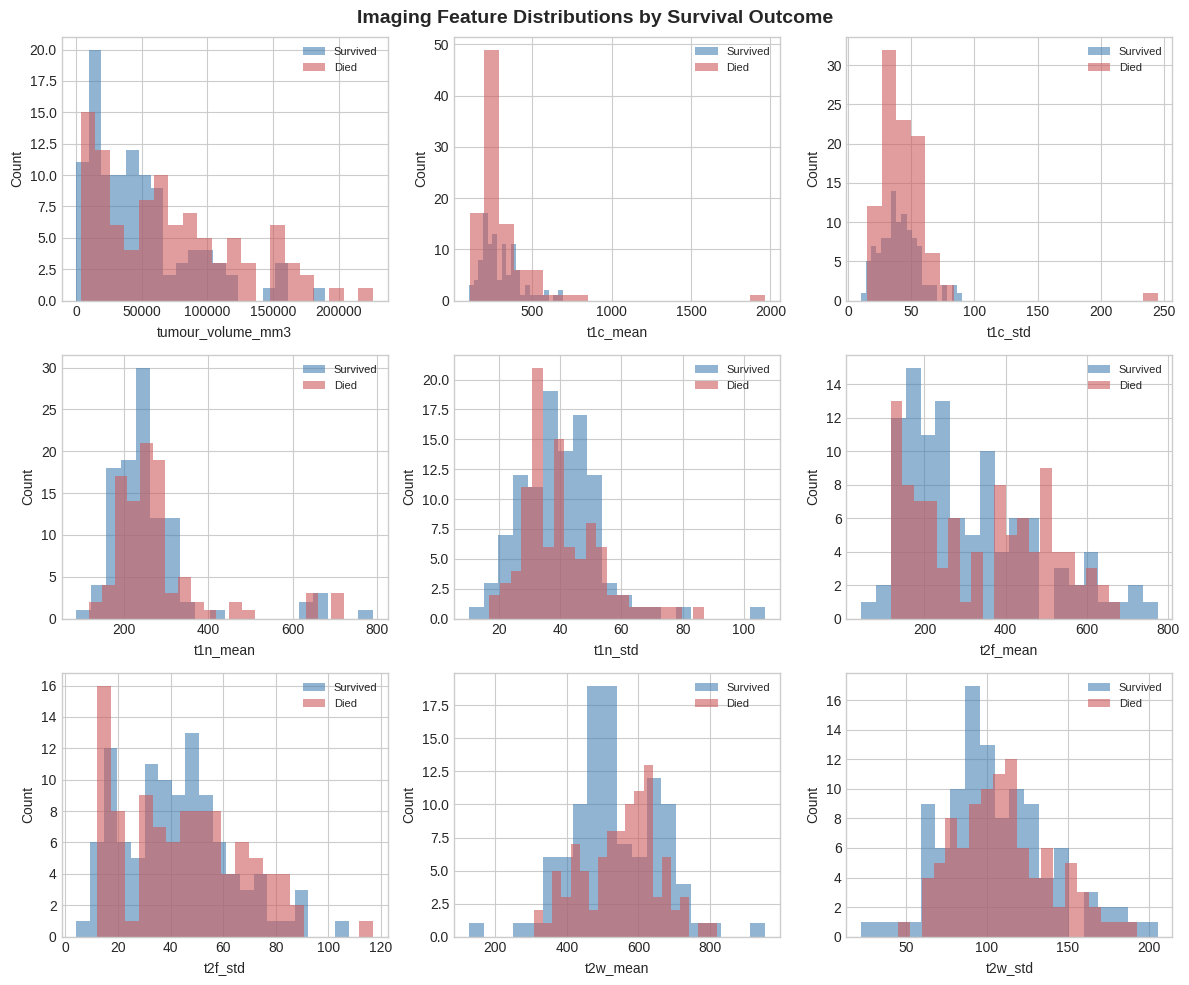

In [56]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

imaging_cols = [c for c in imaging_features.columns if c != 'patient_id']

for i, col in enumerate(imaging_cols):
    ax = axes[i]

    # Get data for alive vs dead
    alive = combined_df[combined_df[target_col] == 0][col]
    dead = combined_df[combined_df[target_col] == 1][col]

    ax.hist(alive, bins=20, alpha=0.6, label='Survived', color='steelblue')
    ax.hist(dead, bins=20, alpha=0.6, label='Died', color='indianred')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)

plt.suptitle('Imaging Feature Distributions by Survival Outcome', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '04_imaging_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

### Compute Image Feature Correlation with Outcome

In [57]:
print("Imaging Features: Correlation with Survival Outcome")
print("-" * 51)

correlations = []
for col in imaging_cols:
    r, p = spearmanr(combined_df[col], combined_df[target_col])
    correlations.append({'feature': col, 'spearman_r': r, 'p_value': p})

corr_df = pd.DataFrame(correlations).sort_values('spearman_r', key=abs, ascending=False)

# Show correlations with outcome, mark statisical significance with '*'
for _, row in corr_df.iterrows():
    sig = '*' if row['p_value'] < 0.05 else ''
    print(f"  {row['feature']:<25} r = {row['spearman_r']:+.3f}  (p = {row['p_value']:.3f}){sig}")

Imaging Features: Correlation with Survival Outcome
---------------------------------------------------
  tumour_volume_mm3         r = +0.221  (p = 0.002)*
  t1n_mean                  r = +0.105  (p = 0.136)
  t2f_mean                  r = +0.100  (p = 0.158)
  t2w_mean                  r = +0.092  (p = 0.195)
  t2w_std                   r = +0.088  (p = 0.212)
  t1c_mean                  r = -0.063  (p = 0.370)
  t2f_std                   r = +0.061  (p = 0.389)
  t1c_std                   r = +0.039  (p = 0.580)
  t1n_std                   r = -0.006  (p = 0.930)


### Tumour Volume Analysis

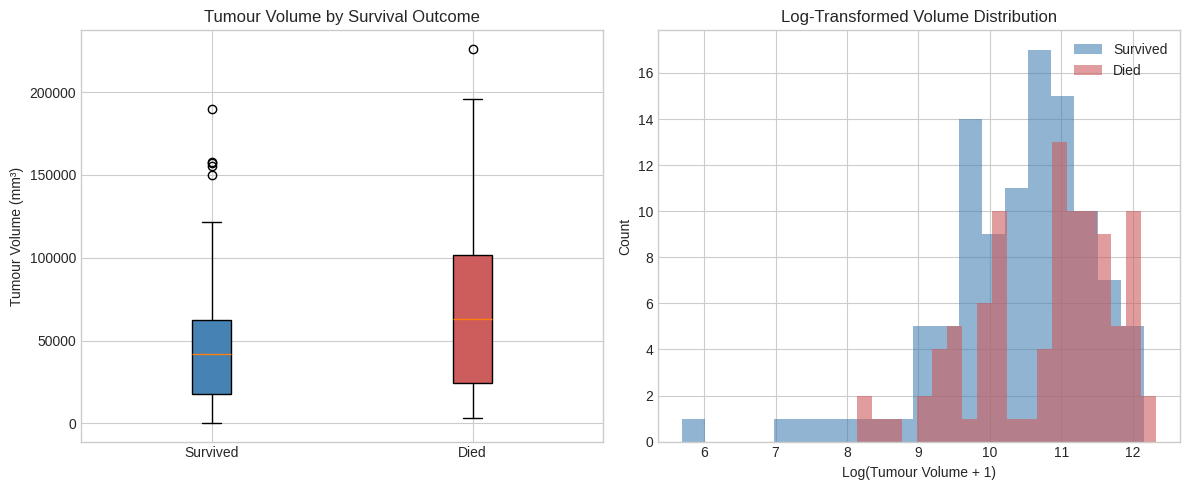


Volume Statistics
-----------------
Survived: median = 42086 mm³, mean = 48301 mm³
Died:     median = 62990 mm³, mean = 70774 mm³


In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Volume distribution by outcome
ax1 = axes[0]
alive_vol = combined_df[combined_df[target_col] == 0]['tumour_volume_mm3']
dead_vol = combined_df[combined_df[target_col] == 1]['tumour_volume_mm3']

bp = ax1.boxplot([alive_vol, dead_vol], labels=['Survived', 'Died'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('indianred')
ax1.set_ylabel('Tumour Volume (mm³)')
ax1.set_title('Tumour Volume by Survival Outcome')

# Log-scale volume distribution
ax2 = axes[1]
combined_df['log_volume'] = np.log1p(combined_df['tumour_volume_mm3'])
ax2.hist(combined_df[combined_df[target_col] == 0]['log_volume'], bins=20, alpha=0.6, label='Survived', color='steelblue')
ax2.hist(combined_df[combined_df[target_col] == 1]['log_volume'], bins=20, alpha=0.6, label='Died', color='indianred')
ax2.set_xlabel('Log(Tumour Volume + 1)')
ax2.set_ylabel('Count')
ax2.set_title('Log-Transformed Volume Distribution')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '04_volume_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVolume Statistics")
print("-" * 17)
print(f"Survived: median = {alive_vol.median():.0f} mm³, mean = {alive_vol.mean():.0f} mm³")
print(f"Died:     median = {dead_vol.median():.0f} mm³, mean = {dead_vol.mean():.0f} mm³")

### Correlation Between Imaging and Clinical Features

In [59]:
# Select key clinical features to compare
clinical_numeric = ['age at diagnosis', 'grade of primary brain tumor']

print("Imaging vs Clinical Feature Correlations")
print("-" * 40)

for clinical_col in clinical_numeric:
    print(f"\n{clinical_col}:")
    for imaging_col in imaging_cols:
        r, p = spearmanr(combined_df[imaging_col], combined_df[clinical_col])
        if abs(r) > 0.15:  # Only show meaningful correlations
            print(f"  vs {imaging_col:<25} r = {r:+.3f}")

Imaging vs Clinical Feature Correlations
----------------------------------------

age at diagnosis:
  vs tumour_volume_mm3         r = +0.194
  vs t1c_mean                  r = -0.223
  vs t2f_std                   r = -0.196
  vs t2w_mean                  r = +0.193

grade of primary brain tumor:
  vs tumour_volume_mm3         r = +0.301
  vs t1c_mean                  r = -0.192


## Prepare Features for Modelling

### Remove Leakage Features

Same features removed in notebooks 02 and 03.

In [60]:
leakage_features = [
    'second progression/recurrence',
    'type of 2nd progression',
    'time to first progression (days)',
    'number of days from diagnosis to date of first progression',
    'number of days from diagnosis to first surgery or procedure',
    'progression',
    'type of 1st progression'
]

# Also remove utility columns
utility_cols = ['patient_id', 'has_imaging', 'log_volume']

all_to_remove = leakage_features + utility_cols + [target_col]
features_to_remove = [f for f in all_to_remove if f in combined_df.columns]

X_combined = combined_df.drop(columns=features_to_remove, errors='ignore')
y_combined = combined_df[target_col]

print(f"Features after leakage removal: {X_combined.shape[1]}")
print(f"Samples: {X_combined.shape[0]}")

Features after leakage removal: 30
Samples: 202


### Create Feature Sets

In [61]:
# Identify clinical vs imaging features
imaging_feature_names = [c for c in imaging_cols if c in X_combined.columns]
clinical_feature_names = [c for c in X_combined.columns if c not in imaging_feature_names]

print(f"Clinical features: {len(clinical_feature_names)}")
print(f"Imaging features: {len(imaging_feature_names)}")

# Create separate feature sets
X_clinical = X_combined[clinical_feature_names].copy()
X_imaging = X_combined[imaging_feature_names].copy()

print(f"\nFeature set shapes:")
print(f"  Clinical only: {X_clinical.shape}")
print(f"  Imaging only:  {X_imaging.shape}")
print(f"  Combined:      {X_combined.shape}")

Clinical features: 21
Imaging features: 9

Feature set shapes:
  Clinical only: (202, 21)
  Imaging only:  (202, 9)
  Combined:      (202, 30)


### Encode Categorical Features

In [62]:
categorical_cols = X_clinical.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Categorical features to encode: {len(categorical_cols)}")
for col in categorical_cols:
    print(f"  - {col}: {X_clinical[col].nunique()} categories")

Categorical features to encode: 4
  - sex at birth: 2 categories
  - race: 4 categories
  - primary diagnosis: 6 categories
  - previous brain tumor: 2 categories


In [63]:
# One-hot encode categorical features
X_clinical_encoded = pd.get_dummies(X_clinical, columns=categorical_cols, drop_first=True)
X_combined_encoded = pd.get_dummies(X_combined, columns=categorical_cols, drop_first=True)

print(f"After encoding:")
print(f"  Clinical: {X_clinical_encoded.shape}")
print(f"  Combined: {X_combined_encoded.shape}")

After encoding:
  Clinical: (202, 27)
  Combined: (202, 36)


### Handle Missing Values

In [64]:
# Check missing values
missing_clinical = X_clinical_encoded.isnull().sum().sum()
missing_imaging = X_imaging.isnull().sum().sum()
missing_combined = X_combined_encoded.isnull().sum().sum()

print(f"Missing values:")
print(f"  Clinical: {missing_clinical}")
print(f"  Imaging:  {missing_imaging}")
print(f"  Combined: {missing_combined}")

# Impute if necessary
if missing_combined > 0:
    imputer = SimpleImputer(strategy='median')
    X_clinical_encoded = pd.DataFrame(
        imputer.fit_transform(X_clinical_encoded),
        columns=X_clinical_encoded.columns,
        index=X_clinical_encoded.index
    )
    X_combined_encoded = pd.DataFrame(
        imputer.fit_transform(X_combined_encoded),
        columns=X_combined_encoded.columns,
        index=X_combined_encoded.index
    )
    print("\nMissing values imputed with median.")

Missing values:
  Clinical: 16
  Imaging:  0
  Combined: 16

Missing values imputed with median.


## Model Training

### Define Cross-Validation Function

In [65]:
def train_and_evaluate(X, y, model_name, n_splits=5):
    """
    Train XGBoost with stratified k-fold cross-validation.
    Returns dictionary with performance metrics.
    """
    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall'
    }

    results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)

    return {
        'name': model_name,
        'n_features': X.shape[1],
        'auc_mean': np.mean(results['test_roc_auc']),
        'auc_std': np.std(results['test_roc_auc']),
        'auc_scores': results['test_roc_auc'].tolist(),
        'accuracy': np.mean(results['test_accuracy']),
        'f1': np.mean(results['test_f1']),
        'precision': np.mean(results['test_precision']),
        'recall': np.mean(results['test_recall']),
        'train_auc': np.mean(results['train_roc_auc'])
    }

### Model 1: Clinical Features Only

In [66]:
print("Training Model 1: Clinical Features Only")
print("-" * 40)

clinical_results = train_and_evaluate(X_clinical_encoded, y_combined, 'Clinical Only')

print(f"Features: {clinical_results['n_features']}")
print(f"AUC: {clinical_results['auc_mean']:.4f} ± {clinical_results['auc_std']:.4f}")
print(f"Accuracy: {clinical_results['accuracy']:.4f}")
print(f"F1: {clinical_results['f1']:.4f}")

Training Model 1: Clinical Features Only
----------------------------------------
Features: 27
AUC: 0.7220 ± 0.0956
Accuracy: 0.7034
F1: 0.7095


### Model 2: Imaging Features Only

In [67]:
print("Training Model 2: Imaging Features Only")
print("-" * 39)

imaging_results = train_and_evaluate(X_imaging, y_combined, 'Imaging Only')

print(f"Features: {imaging_results['n_features']}")
print(f"AUC: {imaging_results['auc_mean']:.4f} ± {imaging_results['auc_std']:.4f}")
print(f"Accuracy: {imaging_results['accuracy']:.4f}")
print(f"F1: {imaging_results['f1']:.4f}")

Training Model 2: Imaging Features Only
---------------------------------------
Features: 9
AUC: 0.6542 ± 0.0543
Accuracy: 0.5840
F1: 0.5601


### Model 3: Combined (Clinical + Imaging)

In [68]:
print("Training Model 3: Combined (Clinical + Imaging)")
print("-" * 47)

combined_results = train_and_evaluate(X_combined_encoded, y_combined, 'Combined')

print(f"Features: {combined_results['n_features']}")
print(f"AUC: {combined_results['auc_mean']:.4f} ± {combined_results['auc_std']:.4f}")
print(f"Accuracy: {combined_results['accuracy']:.4f}")
print(f"F1: {combined_results['f1']:.4f}")

Training Model 3: Combined (Clinical + Imaging)
-----------------------------------------------
Features: 36
AUC: 0.7198 ± 0.0596
Accuracy: 0.6583
F1: 0.6560


## Results Comparison

### Model Comparison Table

In [69]:
comparison = pd.DataFrame([
    clinical_results,
    imaging_results,
    combined_results
])

# Format for display
display_cols = ['name', 'n_features', 'auc_mean', 'auc_std', 'accuracy', 'f1']
comparison_display = comparison[display_cols].copy()
comparison_display.columns = ['Model', 'Features', 'AUC', 'AUC Std', 'Accuracy', 'F1']

print("Model Comparison")
print("-" * 16)
print(comparison_display.to_string(index=False))

Model Comparison
----------------
        Model  Features      AUC  AUC Std  Accuracy       F1
Clinical Only        27 0.721980 0.095631  0.703415 0.709490
 Imaging Only         9 0.654211 0.054258  0.584024 0.560076
     Combined        36 0.719774 0.059567  0.658293 0.656012


### Visualise Model Comparison

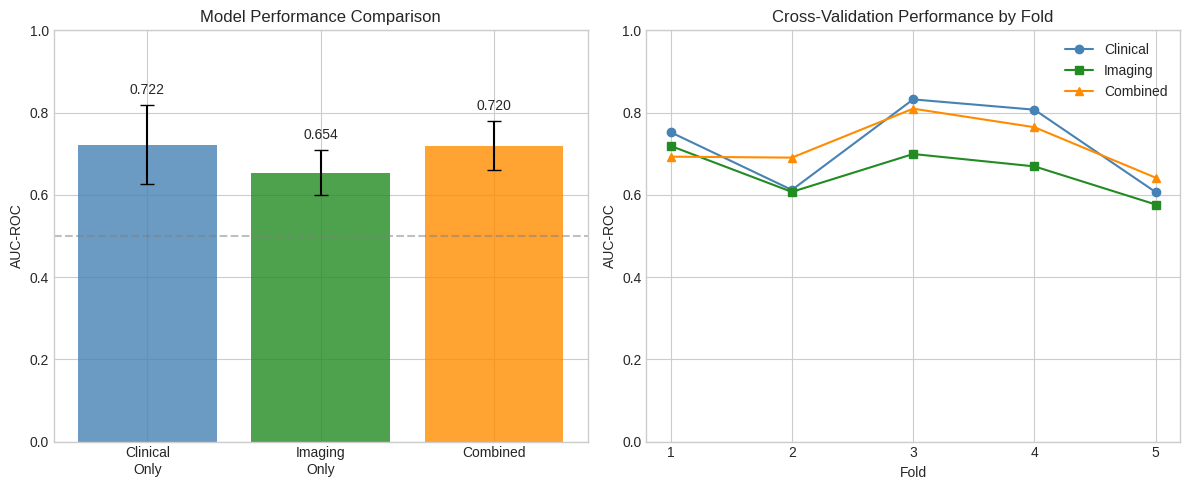

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# AUC comparison
ax1 = axes[0]
models = ['Clinical\nOnly', 'Imaging\nOnly', 'Combined']
aucs = [clinical_results['auc_mean'], imaging_results['auc_mean'], combined_results['auc_mean']]
stds = [clinical_results['auc_std'], imaging_results['auc_std'], combined_results['auc_std']]
colors = ['steelblue', 'forestgreen', 'darkorange']

bars = ax1.bar(models, aucs, yerr=stds, capsize=5, color=colors, alpha=0.8)
ax1.set_ylabel('AUC-ROC')
ax1.set_title('Model Performance Comparison')
ax1.set_ylim(0, 1)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')

# Add value labels
for bar, auc_val, std_val in zip(bars, aucs, stds):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_val + 0.02,
             f'{auc_val:.3f}', ha='center', va='bottom', fontsize=10)

# Fold-by-fold comparison
ax2 = axes[1]
folds = list(range(1, 6))
ax2.plot(folds, clinical_results['auc_scores'], 'o-', label='Clinical', color='steelblue')
ax2.plot(folds, imaging_results['auc_scores'], 's-', label='Imaging', color='forestgreen')
ax2.plot(folds, combined_results['auc_scores'], '^-', label='Combined', color='darkorange')
ax2.set_xlabel('Fold')
ax2.set_ylabel('AUC-ROC')
ax2.set_title('Cross-Validation Performance by Fold')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_xticks(folds)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '04_model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

### Feature Importance (Combined Model)

In [71]:
# Train final model on all data to get feature importance
final_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
final_model.fit(X_combined_encoded, y_combined)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': X_combined_encoded.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Mark imaging features
importance_df['is_imaging'] = importance_df['feature'].isin(imaging_feature_names)

print("Top 15 Features (Combined Model)")
print("-" * 32)
for i, row in importance_df.head(15).iterrows():
    marker = '[IMG]' if row['is_imaging'] else '     '
    print(f"  {marker} {row['feature']:<40} {row['importance']:.4f}")

Top 15 Features (Combined Model)
--------------------------------
        chromosome 7 gain and chromosome 10 loss 0.1069
        primary diagnosis_GBM                    0.1059
        idh1 mutation                            0.0830
        tert promoter mutation                   0.0694
        grade of primary brain tumor             0.0664
        cdkn2a/b deletion                        0.0491
        age at diagnosis                         0.0478
  [IMG] t2w_mean                                 0.0411
  [IMG] t1n_std                                  0.0401
  [IMG] tumour_volume_mm3                        0.0373
        sex at birth_Male                        0.0361
        h3-3a mutation                           0.0282
  [IMG] t2w_std                                  0.0278
  [IMG] t2f_std                                  0.0272
  [IMG] t1c_std                                  0.0271


### Visualise Feature Importance

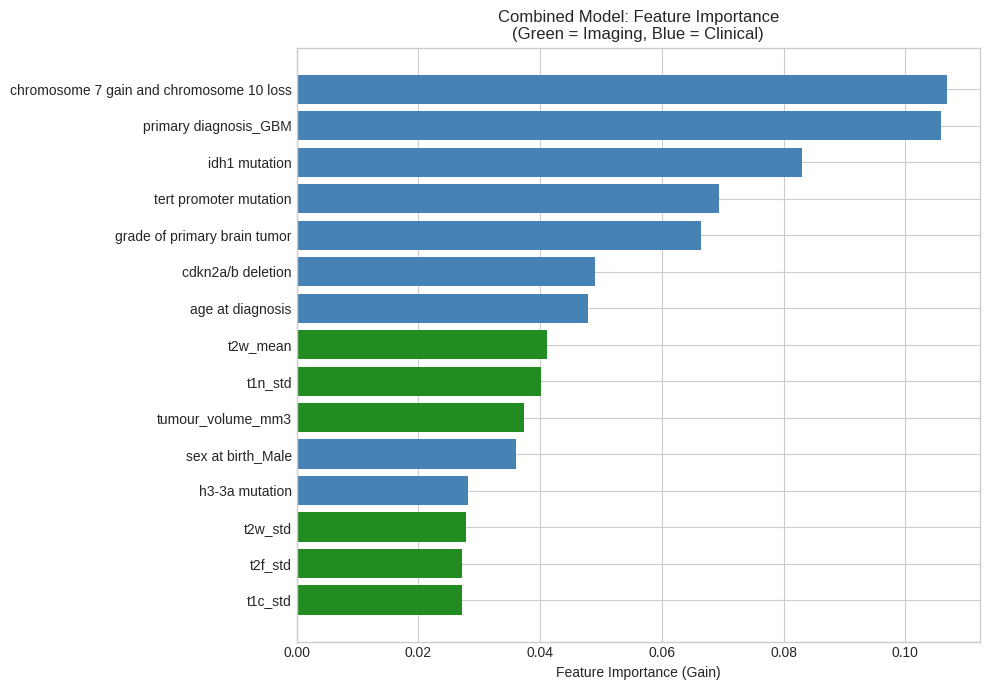


Imaging features contribute 27.7% of total importance


In [72]:
top_n = 15
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 7))

colors = ['forestgreen' if is_img else 'steelblue' for is_img in top_features['is_imaging']]

bars = ax.barh(range(len(top_features)), top_features['importance'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title('Combined Model: Feature Importance\n(Green = Imaging, Blue = Clinical)')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '04_feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

# Summary of imaging feature contribution
imaging_importance = importance_df[importance_df['is_imaging']]['importance'].sum()
total_importance = importance_df['importance'].sum()
print(f"\nImaging features contribute {imaging_importance/total_importance*100:.1f}% of total importance")

### Statistical Test: Does Imaging Add Value?

In [73]:
from scipy.stats import ttest_rel, wilcoxon

# Paired t-test on fold-level AUCs
clinical_aucs = np.array(clinical_results['auc_scores'])
combined_aucs = np.array(combined_results['auc_scores'])

# Difference
diff = combined_aucs - clinical_aucs

print("Statistical Comparison: Combined vs Clinical-Only")
print("-" * 49)
print(f"\nFold-level AUC differences:")
for i, d in enumerate(diff, 1):
    print(f"  Fold {i}: {d:+.4f}")

print(f"\nMean difference: {diff.mean():+.4f}")
print(f"Std difference:  {diff.std():.4f}")

# Paired t-test (requires normality assumption)
t_stat, p_value = ttest_rel(combined_aucs, clinical_aucs)
print(f"\nPaired t-test: t = {t_stat:.3f}, p = {p_value:.3f}")

# Wilcoxon signed-rank test (non-parametric)
try:
    w_stat, w_p = wilcoxon(combined_aucs, clinical_aucs)
    print(f"Wilcoxon test:  W = {w_stat:.3f}, p = {w_p:.3f}")
except ValueError as e:
    print(f"Wilcoxon test: Could not compute (likely identical values)")

# Interpretation
if p_value < 0.05:
    print(f"\nConclusion: Imaging features significantly {'improve' if diff.mean() > 0 else 'decrease'} performance (p < 0.05)")
else:
    print(f"\nConclusion: No significant difference between combined and clinical-only models (p = {p_value:.3f})")

Statistical Comparison: Combined vs Clinical-Only
-------------------------------------------------

Fold-level AUC differences:
  Fold 1: -0.0595
  Fold 2: +0.0786
  Fold 3: -0.0226
  Fold 4: -0.0426
  Fold 5: +0.0351

Mean difference: -0.0022
Std difference:  0.0515

Paired t-test: t = -0.086, p = 0.936
Wilcoxon test:  W = 7.000, p = 1.000

Conclusion: No significant difference between combined and clinical-only models (p = 0.936)


## Save Results

### Save Model Comparison

In [74]:
results_dir = os.path.join(GLIOMA_DIR, 'results')
os.makedirs(results_dir, exist_ok=True)

radiomics_results = {}

model_results = [
    clinical_results,
    imaging_results,
    combined_results
]

for res in model_results:
    model_name_key = res['name'].lower().replace(' ', '_')
    radiomics_results[model_name_key] = {
        'auc_mean': float(res['auc_mean']),
        'auc_std': float(res['auc_std']),
        'auc_scores': res['auc_scores'],
        'accuracy': float(res['accuracy']),
        'f1': float(res['f1']),
        'n_features': int(res['n_features'])
    }

radiomics_results['statistical_test'] = {
    'paired_ttest_p': float(p_value),
    'mean_auc_difference': float(diff.mean())
}

radiomics_results['metadata'] = {
    'n_patients': int(len(y_combined)),
    'imaging_features': imaging_feature_names,
    'patients_missing_imaging': int(len(clinical_only))
}

with open(os.path.join(results_dir, '04_radiomics_results.json'), 'w') as f:
    json.dump(radiomics_results, f, indent=2)

print("Saved: 04_radiomics_results.json")

Saved: 04_radiomics_results.json


### Save Feature Importance

In [75]:
importance_df.to_csv(os.path.join(results_dir, '04_combined_feature_importance.csv'), index=False)
print("Saved: 04_combined_feature_importance.csv")

Saved: 04_combined_feature_importance.csv


### Save Imaging Features Dataset

In [76]:
preprocessed_dir = os.path.join(GLIOMA_DIR, 'preprocessed')

imaging_features.to_pickle(os.path.join(preprocessed_dir, 'imaging_features.pkl'))
print("Saved: 04_imaging_features.pkl")

combined_df.to_pickle(os.path.join(preprocessed_dir, 'combined_clinical_imaging.pkl'))
print("Saved: 04_combined_clinical_imaging.pkl")

Saved: 04_imaging_features.pkl
Saved: 04_combined_clinical_imaging.pkl


## Summary

This notebook integrated imaging-derived features with clinical data to test whether tumour characteristics from MRI add predictive value.

**Key findings:**

1. **Data availability**: 173 of 203 patients have imaging data (30 missing)

2. **Imaging features**: 9 features extracted from first post-treatment MRI:
   - Tumour volume
   - Intensity statistics (mean, stdev) for T1c, T1n, T2f, T2w

3. **Model performance comparison**: See results table above

4. **Feature importance**: Clinical features (age, grade, molecular markers) remain dominant; imaging features contribute a smaller fraction of total importance

**Interpretation:**

- If combined model significantly outperforms clinical-only: imaging provides complementary prognostic information
- If no significant difference: clinical/molecular features already capture the relevant prognostic signal
- If imaging-only performs poorly: first-order intensity statistics alone lack discriminative power; texture features or longitudinal changes may be needed

**For the report:**
- Compare AUC across all notebooks (02: binary, 03: survival, 04: radiomics)
- Discuss whether imaging integration justifies the additional complexity
- Note the 30 patients excluded due to missing imaging data